In [1186]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import odeint
import neurokit2 as nk  # Load the package

## Neural kit 2 sample

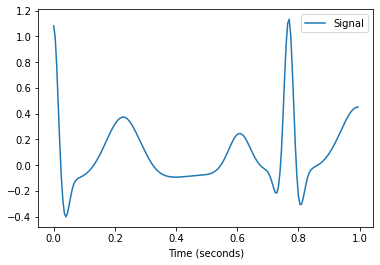

In [1187]:
# use neuralkit2 for McSharry equation

simulated_ecg = nk.ecg_simulate(duration=1, sampling_rate=200, heart_rate=80)

nk.signal_plot(simulated_ecg, sampling_rate=200) 

## Solve system of ODE

In [1188]:
import autograd.numpy as np
from autograd import grad, elementwise_grad, jacobian
import autograd.numpy.random as npr
from autograd.misc.optimizers import adam

def init_random_params(scale, layer_sizes, rs=npr.RandomState(0)):
    """Build a list of (weights, biases) tuples, one for each layer."""
    return [(rs.randn(insize, outsize) * scale,   # weight matrix
             rs.randn(outsize) * scale)           # bias vector
            for insize, outsize in zip(layer_sizes[:-1], layer_sizes[1:])]

def swish(x):
    print("x: ", x)
    return x / (1.0 + np.exp(-x))

def C(params, inputs):
    "Neural network functions"
    for W, b in params:
        outputs = np.dot(inputs, W) + b
        inputs = swish(outputs)
    return outputs

# initial guess for the weights and biases
params = init_random_params(0.1, layer_sizes=[1, 8, 3])

In [1189]:
# Derivatives
jac = jacobian(C, 1)
def dCdt(params, t):
    i = np.arange(len(t))
    return jac(params, t)[i, :, i].reshape((len(t), 3))

In [1190]:
# C0 = [1.0, 0.0, 0.0] # intitial condition

# t = np.linspace(0, 10, 25).reshape((-1, 1))
# params = init_random_params(0.1, layer_sizes=[1, 8, 3])
# i = 0    # number of training steps
# N = 500  # epochs for training
# et = 0.0 # total elapsed time

In [1191]:
# def objective(params, step):
#     Ca, Cb, Cc = C(params, t).T
#     dCadt, dCbdt, dCcdt = dCdt(params, t).T
    
#     z1 = np.sum((dCadt + Ca)**2)
#     z2 = np.sum((dCbdt - Ca + Cb)**2)
#     z3 = np.sum((dCcdt - Cb)**2)

#     ic = np.sum((np.array([Ca[0], Cb[0], Cc[0]]) - C0)**2)  # initial conditions

#     return z1 + z2 + z3 + ic

# def callback(params, step, g):
#     if step % 100 == 0:
#         print("Iteration {0:3d} objective {1}".format(step,
#                                                       objective(params, step)))

# objective(params, 0)

In [1192]:
# params = adam(grad(objective), params,
#               step_size=0.005, num_iters=N, callback=callback)

In [1193]:
# plt.plot(t, C(params, t), '-')
# plt.legend(['Ann', 'Bnn', 'Cnn'])
# plt.xlabel('Time')
# plt.ylabel('C')

## Pytorch

In [1194]:
## let's import the relevant libraries
import torch
import torch.nn as nn
from torch.autograd.functional import jacobian
import matplotlib.pyplot as plt
import numpy as np

## check if GPU is available and use it; otherwise use CPU
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

In [1195]:
# full connected network
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.silu = nn.SiLU()
        self.l2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = self.l1(x)
        out = self.silu(out)
        out = self.l2(out)
        return out

# N is a Neural Network - has 1 hidden layer
N = NeuralNet(1, 8, 3).to(device)

In [1196]:
def derivative(func, input):
    jac = jacobian(func, input)

    i = np.arange(len(input))
    return jac[i, :, i].reshape((len(input), 3))

## McSharry equation

In [1197]:
import math

import numpy as np
import pandas as pd
import scipy


In [1198]:
def signal_resample(
    signal, desired_length=None, sampling_rate=None, desired_sampling_rate=None, method="interpolation"
):
    if desired_length is None:
        desired_length = int(np.round(len(signal) * desired_sampling_rate / sampling_rate))

    # Sanity checks
    if len(signal) == desired_length:
        return signal

    # Resample
    if method.lower() == "fft":
        resampled = _resample_fft(signal, desired_length)
    elif method.lower() == "poly":
        resampled = _resample_poly(signal, desired_length)
    elif method.lower() == "numpy":
        resampled = _resample_numpy(signal, desired_length)
    elif method.lower() == "pandas":
        resampled = _resample_pandas(signal, desired_length)
    else:
        resampled = _resample_interpolation(signal, desired_length)

    return resampled


# =============================================================================
# Methods
# =============================================================================
def _resample_numpy(signal, desired_length):
    resampled_signal = np.interp(
        np.linspace(0.0, 1.0, desired_length, endpoint=False),  # where to interpolate
        np.linspace(0.0, 1.0, len(signal), endpoint=False),  # known positions
        signal,  # known data points
    )
    return resampled_signal


def _resample_interpolation(signal, desired_length):
    resampled_signal = scipy.ndimage.zoom(signal, desired_length / len(signal))
    return resampled_signal


def _resample_fft(signal, desired_length):
    resampled_signal = scipy.signal.resample(signal, desired_length)
    return resampled_signal


def _resample_poly(signal, desired_length):
    resampled_signal = scipy.signal.resample_poly(signal, desired_length, len(signal))
    return resampled_signal


def _resample_pandas(signal, desired_length):
    # Convert to Time Series
    index = pd.date_range("20131212", freq="L", periods=len(signal))
    resampled_signal = pd.Series(signal, index=index)

    # Create resampling factor
    resampling_factor = str(np.round(1 / (desired_length / len(signal)), 6)) + "L"

    # Resample
    resampled_signal = resampled_signal.resample(resampling_factor).bfill().values

    # Sanitize
    resampled_signal = _resample_sanitize(resampled_signal, desired_length)

    return resampled_signal


# =============================================================================
# Internals
# =============================================================================
def _resample_sanitize(resampled_signal, desired_length):
    # Adjust extremities
    diff = len(resampled_signal) - desired_length
    if diff < 0:
        resampled_signal = np.concatenate([resampled_signal, np.full(np.abs(diff), resampled_signal[-1])])
    elif diff > 0:
        resampled_signal = resampled_signal[0:desired_length]
    return resampled_signal

In [1199]:
def ecg_simulate(
    duration=10, length=None, sampling_rate=1000, noise=0.01, heart_rate=70, heart_rate_std=1, method="ecgsyn", random_state=None
):

    # Seed the random generator for reproducible results
    np.random.seed(random_state)

    # Generate number of samples automatically if length is unspecified
    if length is None:
        length = duration * sampling_rate
    if duration is None:
        duration = length / sampling_rate

    # Run appropriate method
    if method.lower() in ["simple", "daubechies"]:
        ecg = _ecg_simulate_daubechies(
            duration=duration, length=length, sampling_rate=sampling_rate, heart_rate=heart_rate
        )
    else:
        approx_number_beats = int(np.round(duration * (heart_rate / 60)))
        ecg = _ecg_simulate_ecgsyn(
            sfecg=sampling_rate,
            N=approx_number_beats,
            Anoise=0,
            hrmean=heart_rate,
            hrstd=heart_rate_std,
            lfhfratio=0.5,
            sfint=sampling_rate,
            ti=(-70, -15, 0, 15, 100),
            ai=(1.2, -5, 30, -7.5, 0.75),
            bi=(0.25, 0.1, 0.1, 0.1, 0.4),
        )
        # Cut to match expected length
        ecg = ecg[0:length]

    # Add random noise
    if noise > 0:
        ecg = signal_distort(
            ecg,
            sampling_rate=sampling_rate,
            noise_amplitude=noise,
            noise_frequency=[5, 10, 100],
            noise_shape="laplace",
            random_state=random_state,
            silent=True,
        )

    # Reset random seed (so it doesn't affect global)
    np.random.seed(None)
    return ecg



# =============================================================================
# Daubechies
# =============================================================================
def _ecg_simulate_daubechies(duration=10, length=None, sampling_rate=1000, heart_rate=70):
    # The "Daubechies" wavelet is a rough approximation to a real, single, cardiac cycle
    cardiac = scipy.signal.wavelets.daub(10)

    # Add the gap after the pqrst when the heart is resting.
    cardiac = np.concatenate([cardiac, np.zeros(10)])

    # Caculate the number of beats in capture time period
    num_heart_beats = int(duration * heart_rate / 60)

    # Concatenate together the number of heart beats needed
    ecg = np.tile(cardiac, num_heart_beats)

    # Change amplitude
    ecg = ecg * 10

    # Resample
    ecg = signal_resample(
        ecg, sampling_rate=int(len(ecg) / 10), desired_length=length, desired_sampling_rate=sampling_rate
    )

    return ecg

# =============================================================================
# ECGSYN
# =============================================================================
def _ecg_simulate_ecgsyn(
    sfecg=256,
    N=256,
    Anoise=0,
    hrmean=60,
    hrstd=1,
    lfhfratio=0.5,
    sfint=512.0,
    ti=(-70, -15, 0, 15, 100),
    ai=(1.2, -5, 30, -7.5, 0.75),
    bi=(0.25, 0.1, 0.1, 0.1, 0.4),
):

    if not isinstance(ti, np.ndarray):
        ti = np.array(ti)
    if not isinstance(ai, np.ndarray):
        ai = np.array(ai)
    if not isinstance(bi, np.ndarray):
        bi = np.array(bi)

    ti = ti * np.pi / 180

    # Adjust extrema parameters for mean heart rate
    hrfact = np.sqrt(hrmean / 60)
    hrfact2 = np.sqrt(hrfact)
    bi = hrfact * bi
    ti = np.array([hrfact2, hrfact, 1, hrfact, hrfact2]) * ti

    # Check that sfint is an integer multiple of sfecg
    q = np.round(sfint / sfecg)
    qd = sfint / sfecg
    if q != qd:
        raise ValueError(
            "Internal sampling frequency (sfint) must be an integer multiple of the ECG sampling frequency"
            " (sfecg). Your current choices are: sfecg = " + str(sfecg) + " and sfint = " + str(sfint) + "."
        )

    # Define frequency parameters for rr process
    # flo and fhi correspond to the Mayer waves and respiratory rate respectively
    flo = 0.1
    fhi = 0.25
    flostd = 0.01
    fhistd = 0.01
 
    # Calculate time scales for rr and total output
    sfrr = 1
    trr = 1 / sfrr
    rrmean = 60 / hrmean
    n = 2 ** (np.ceil(np.log2(N * rrmean / trr)))

    rr0 = _ecg_simulate_rrprocess(flo, fhi, flostd, fhistd, lfhfratio, hrmean, hrstd, sfrr, n)

    # Upsample rr time series from 1 Hz to sfint Hz
    rr = signal_resample(rr0, sampling_rate=1, desired_sampling_rate=sfint)

    # Make the rrn time series
    dt = 1 / sfint
    rrn = np.zeros(len(rr))
    tecg = 0
    i = 0
    while i < len(rr):
        tecg += rr[i]
        ip = int(np.round(tecg / dt))
        rrn[i:ip] = rr[i]
        i = ip
    Nt = ip

    # Intial condition
    x0 = torch.tensor([1.0, 0.0, 0.04])

    # data range
    t = torch.Tensor(np.linspace(0, (Nt - 1) * dt, Nt)[:, None])

    # =============================================================================
    # ODE solver by PINNs
    # =============================================================================
    l_total = loss(t, rrn, torch.tensor(ti), sfint, torch.tensor(ai), torch.tensor(bi), x0)
    print(l_total)

    ### loss function is done => next step is that starting the train progress


    return 0

# =============================================================================
# Loss funtion for PINNs
# =============================================================================
def loss(t, rr, ti, sfint, ai, bi, X0):
    x, y, z = N(t).T
    dxdt, dydt, dzdt = derivative(N, t).T

    ## x, y dimensions
    r0 = 1
    a0 = 1.0 - torch.sqrt(x ** 2 + y ** 2) / r0

    ip = torch.floor(t * sfint).int()
    w0 = torch.tensor(2 * np.pi / rr[torch.minimum(ip, torch.full(ip.size(), len(rr) - 1))]).T

    l_x = torch.sum((dxdt - a0 * x + w0 * y)**2)
    l_y = torch.sum((dydt - a0 * y - w0 * x)**2)
    
    ## z dimension
    ta = torch.atan2(y, x).unsqueeze(1).repeat(1, ti.size()[0])
    ti = ti.repeat(ta.size()[0], 1)

    dti = (ta - ti) - torch.round((ta - ti) / 2 / np.pi) * 2 * np.pi

    ai = ai.repeat(dti.size()[0], 1)
    bi = bi.repeat(dti.size()[0], 1)

    fresp = 0.25
    zbase = 0.005 * torch.sin(2 * np.pi * fresp * t).flatten()

    l_z = torch.sum((dzdt + torch.sum(ai * dti * torch.exp(-0.5 * (dti / bi) ** 2), dim = 1) + 1 * (z - zbase))**2)

    # ic = torch.sum((np.array([x[0], y[0], z[0]]) - X0)**2)  # initial conditions
    return l_x + l_y + l_z 

def _ecg_simulate_rrprocess(
    flo=0.1, fhi=0.25, flostd=0.01, fhistd=0.01, lfhfratio=0.5, hrmean=60, hrstd=1, sfrr=1, n=256
):
    w1 = 2 * np.pi * flo
    w2 = 2 * np.pi * fhi
    c1 = 2 * np.pi * flostd
    c2 = 2 * np.pi * fhistd
    sig2 = 1
    sig1 = lfhfratio
    rrmean = 60 / hrmean
    rrstd = 60 * hrstd / (hrmean * hrmean)

    df = sfrr / n
    w = np.arange(n) * 2 * np.pi * df
    dw1 = w - w1
    dw2 = w - w2

    Hw1 = sig1 * np.exp(-0.5 * (dw1 / c1) ** 2) / np.sqrt(2 * np.pi * c1 ** 2)
    Hw2 = sig2 * np.exp(-0.5 * (dw2 / c2) ** 2) / np.sqrt(2 * np.pi * c2 ** 2)
    Hw = Hw1 + Hw2
    Hw0 = np.concatenate((Hw[0 : int(n / 2)], Hw[int(n / 2) - 1 :: -1]))
    Sw = (sfrr / 2) * np.sqrt(Hw0)

    ph0 = 2 * np.pi * np.random.uniform(size=int(n / 2 - 1))
    ph = np.concatenate([[0], ph0, [0], -np.flipud(ph0)])
    SwC = Sw * np.exp(1j * ph)
    x = (1 / n) * np.real(np.fft.ifft(SwC))

    xstd = np.std(x)
    ratio = rrstd / xstd
    return rrmean + x * ratio  # Return RR

In [1200]:
duration=1
length=None 
sampling_rate=1000
noise=0.01
heart_rate=70
heart_rate_std=1
method="ecgsyn"
random_state=None

np.random.seed(random_state)

# Generate number of samples automatically if length is unspecified
if length is None:
    length = duration * sampling_rate
if duration is None:
    duration = length / sampling_rate

# Run appropriate method
approx_number_beats = int(np.round(duration * (heart_rate / 60)))
ecg = _ecg_simulate_ecgsyn(
    sfecg=sampling_rate,
    N=approx_number_beats,
    Anoise=0,
    hrmean=heart_rate,
    hrstd=heart_rate_std,
    lfhfratio=0.5,
    sfint=sampling_rate,
    ti=(-70, -15, 0, 15, 100),
    ai=(1.2, -5, 30, -7.5, 0.75),
    bi=(0.25, 0.1, 0.1, 0.1, 0.4),
)
# Cut to match expected length
ecg = ecg[0:length]

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# plot results
plt.plot(ecg[2])
plt.ylabel('z')
figure(figsize=(12, 9), dpi=180)
plt.show()

tensor(13280.2705, dtype=torch.float64, grad_fn=<AddBackward0>)


TypeError: 'int' object is not subscriptable